# 1. Introduction
This notebook is used to process the raw data in order to obtain labelled images for training in a deep learning network. The order of steps is as follows:
1. Replace the "banners" in the images by using reflective padding 
2. Apply the watershed algorithm to the image in order to obtain markers for the segments in the image and save them to the Processed_Data subdirectory
3. After manually determining which images have been successfully labelled using the watershed algorithm, move them into a new subdirectory and use ImageJ to segment the unsuccesfully labelled images

# 2. Import Libraries and Define Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import time as time

from scipy.ndimage import label
from skimage.feature import peak_local_max
from skimage.morphology import watershed

from pathlib import Path

In [2]:
def reflective_pad(img, remove_box):
    """
    Replaces "remove_box" in the img with reflective padding. The "remove_box" input is an array the same size 
    as img but with all 0's in the region where the banner is.
    """
    banner = np.argwhere(remove_box == 0)
    banner_x1, banner_y1 = banner[0, 1], banner[0, 0]
    banner_x2, banner_y2 = banner[-1, 1], banner[-1, 0]

    banner_width, banner_height = banner_x2 - banner_x1, banner_y2 - banner_y1

    bot_reflect = img[banner_y2:int(np.ceil(banner_y2 + banner_height / 2)), banner_x1:banner_x2, :]
    bot_reflect = np.flipud(bot_reflect)

    top_reflect = img[banner_y1 - (banner_height - len(bot_reflect)):banner_y1, banner_x1:banner_x2, :]
    top_reflect = np.flipud(top_reflect)


    reflect_pad = np.concatenate((top_reflect, bot_reflect), axis = 0)
    
    imgcopy = img.copy()
    imgcopy = img.copy()
    imgcopy[banner_y1:banner_y2, banner_x1:banner_x2] = reflect_pad
    
    return imgcopy

In [3]:
def remove_banners(img, threshold = 250, vert_kern = 13, hori_kern = 13, kern = 5, alpha = 0.5):
    """removes banners in the image and replaces it with reflective padding"""
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    
    # Find the verticle and horizontal lines in the image
    verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, vert_kern))
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (hori_kern, 1))
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kern, kern))
    
    img_v = cv2.erode(thresh, verticle_kernel, iterations = 3)
    vert_lines_img = cv2.dilate(img_v, verticle_kernel, iterations = 3)    
    img_h = cv2.erode(thresh, horizontal_kernel, iterations = 3)
    hori_lines_img = cv2.dilate(img_h, horizontal_kernel, iterations = 3)
    
    # Find where the banner is using the verticle and horizontal line segmenters
    img_final = cv2.addWeighted(vert_lines_img, alpha, hori_lines_img, 1. - alpha, 0.0)
    img_final = cv2.erode(~img_final, kernel, iterations = 2)
    
    ret, thresh2 = cv2.threshold(img_final, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    result = reflective_pad(img, thresh2)
    return result
    

In [4]:
def apply_watershed(img, invert = False, min_distance_bt_peaks = 20):
    """
    Apply the watershed algorithm to the img
    """
    shifted = cv2.pyrMeanShiftFiltering(img, 21, 51)  # remove noise using a mean filter
    graycopy = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(graycopy, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    if invert == True:
        thresh = 255 - thresh
        
    dt = cv2.distanceTransform(thresh, 2, 3)  # apply the distance transform to obtain regions we know where objects are
    localmax = peak_local_max(dt, indices = False, min_distance = min_distance_bt_peaks, labels = thresh)
    
    markers, num_seg = label(localmax, structure = np.ones((3, 3)))
    labels = watershed(-dt, markers, mask = thresh)
    
    return labels, num_seg
    
    

# 3. Load in the Data

In [6]:
subdir = 'Films_Coated_Surface'  # subdirectory name

raw_p =  Path(f'../data/Raw_Data/{subdir}')
processed_p = Path(f'../data/Processed_Data/Labelled/{subdir}')

# Create list of files that have already been previously processed
labelled_list = [x for x in processed_p.glob('**/*.jpg') if x.is_file() and '_seg' not in str(x).split('\\')[-1]]
labelled_list = [str(x).split('\\')[-1] for x in labelled_list]

# Create list of files in the subdirectory that have yet to be processed
file_list = [x for x in raw_p.glob('**/*') if x.is_file() and str(x).split('\\')[-1] not in labelled_list]  # extracts all files from directory into a list

print (f'num files = {len(file_list)}')
print(f'num labelled files = {len(labelled_list)}')

num files = 247
num labelled files = 62


# 4. Remove Banners and Apply Watershed
The next cell performs the segmentation on a random sample of 100 files taken from the previously loaded data. Since there is still a lot of variation in the images, the above functions do not work for every image and the cell will probably run into an error before it completes. However, since the file that caused the error will be in the Processed_Data subdirectory, if you run the section 3 cell again, the "problem file" won't appear when you run the below cell a second time. 

In [7]:
rand_files = np.random.choice(file_list, 100, replace = False)
start = time.time()
for i, file in enumerate(rand_files):
    print(f'file number = {i}')
    print(f'time = {time.time() - start}')
    
    name = str(file).split('.')[-2].split('\\')[-1]
    img = mpimg.imread(file)
    cv2.imwrite(f'../data/Processed_Data/Labelled/{subdir}/{name}.jpg', img)  # save a copy of the raw image into the Processed_Data subdirectory
    
    bannerless = remove_banners(img)
    seg, num_seg = apply_watershed(bannerless)
    cv2.imwrite(f'../data/Processed_Data/Labelled/{subdir}/{name}_seg{num_seg}.jpg', seg)  # save the labelled image into the Processed_Data subdirectory

file number = 0
time = 0.0
file number = 1
time = 5.315624952316284
file number = 2
time = 6.3892223834991455
file number = 3
time = 7.638766527175903
file number = 4
time = 18.581623077392578
file number = 5
time = 19.89465618133545
file number = 6
time = 47.985963344573975
file number = 7
time = 52.62804675102234
file number = 8
time = 69.40681266784668
file number = 9
time = 73.86220192909241
file number = 10
time = 80.83504223823547
file number = 11
time = 85.66604208946228
file number = 12
time = 97.46835136413574
file number = 13
time = 106.0560564994812
file number = 14
time = 107.42877149581909
file number = 15
time = 110.88783264160156
file number = 16
time = 117.56669282913208
file number = 17
time = 162.38569355010986
file number = 18
time = 190.26421546936035


ValueError: could not broadcast input array from shape (67,116,3) into shape (583,116,3)

# 5. Manual Methods using ImageJ
After trying to label as many images using the above for loop as I can, I now go into the subdirectory and filter through which were successfully segmented and which were not. The ones that were successfully segmented are moved to another folder while the unsuccessful ones are to be manually segmented using ImageJ. Since the images saved still have the banners in them, I have to reapply the remove_banners function to begin segmenting them using ImageJ.

In [24]:
p =  Path(f'../data/Processed_Data/Labelled/{subdir}')
file_list = [x for x in p.glob('*.jpg') if x.is_file() and '_seg' not in str(x).split('\\')[-1]]  # extracts all files from directory into a list

for file in file_list:  
    print(file)
    name = str(file).split('.')[-2].split('\\')[-1]
    img = mpimg.imread(file)
    
    bannerless = remove_banners(img)
    cv2.imwrite(f'../data/Processed_Data/Labelled/{subdir}/{name}.jpg', bannerless)

..\data\Processed_Data\Labelled\Nanowires\L6_723a23bad746d3cb013d9d76b9a50e22.jpg
..\data\Processed_Data\Labelled\Nanowires\L6_750d50d3b3e6187c638b230819d0263d.jpg
..\data\Processed_Data\Labelled\Nanowires\L6_91c0b55a2949aa68ef2c5092e34f0a4e.jpg
..\data\Processed_Data\Labelled\Nanowires\L6_97440d083ff3f076d3b22a8e78aaa9c9.jpg
..\data\Processed_Data\Labelled\Nanowires\L6_98154f10ac2efd503db4370d192828fa.jpg
..\data\Processed_Data\Labelled\Nanowires\L6_9bc4ef0fa790439531b959099173970f.jpg
..\data\Processed_Data\Labelled\Nanowires\L6_9eceb463552f4745820734c5be5d5834.jpg
..\data\Processed_Data\Labelled\Nanowires\L6_a670cfbd5660524fbc8fe53e3f713d8f.jpg
..\data\Processed_Data\Labelled\Nanowires\L6_aa4e39c7562798c7c64a7dc6cbd0ddb8.jpg
..\data\Processed_Data\Labelled\Nanowires\L6_b035e97c8a33d73e483a4fce0f3bd82c.jpg
..\data\Processed_Data\Labelled\Nanowires\L6_b5dac93f0bed25f0e6aeb91e9a0c75ec.jpg
..\data\Processed_Data\Labelled\Nanowires\L6_c5a22d6dc3c5320bb21afa465378d141.jpg
..\data\Processe

# 6. Further Preprocessing
After applying the above steps, there still remain some images that need different modes of preprocessing to be succesfully segmented. For some, it is simply changing some of the arguments in the remove_banners & apply_watershed functions but for others, it requires some more experimentation. I try to be quick with them but regardless, the below cells are very experimental.

(-0.5, 1023.5, 767.5, -0.5)

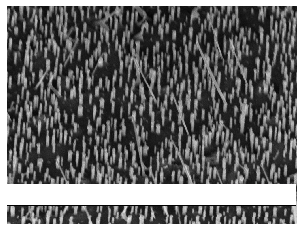

In [6]:
p = Path(f'../data/Processed_Data/Labelled/{subdir}/More_Preprocessing')
filename = 'L6_2142a59abb1cb5b5b97ea298e299764e.jpg'
filepath = p/f'{filename}'

img = mpimg.imread(filepath)
plt.imshow(img)
plt.axis('off')

425


(-0.5, 1023.5, 767.5, -0.5)

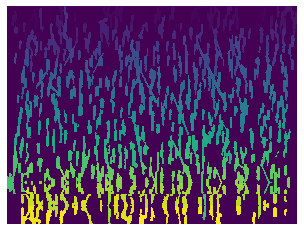

In [8]:
bannerless = remove_banners(img)
seg, num_seg = apply_watershed(bannerless)
cv2.imwrite(f'../data/Processed_Data/Labelled/{subdir}/More_Preprocessing/{filename}_seg{num_seg}', seg)
print(num_seg)
plt.imshow(seg)
plt.axis('off')

In [7]:
# img = cv2.pyrMeanShiftFiltering(img, 21, 51)
# graycopy = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# ret, thresh = cv2.threshold(graycopy, 150, 255, cv2.THRESH_BINARY)
# # cv2.imwrite(f'../data/Processed_Data/Labelled/{subdir}/More_Preprocessing/{filename}_seg', thresh)
# fig, ax = plt.subplots(1, 1, figsize = (18, 16))
# ax.imshow(img)
# plt.axis('off')

224


(-0.5, 1023.5, 767.5, -0.5)

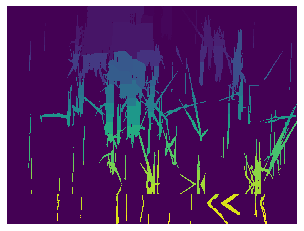

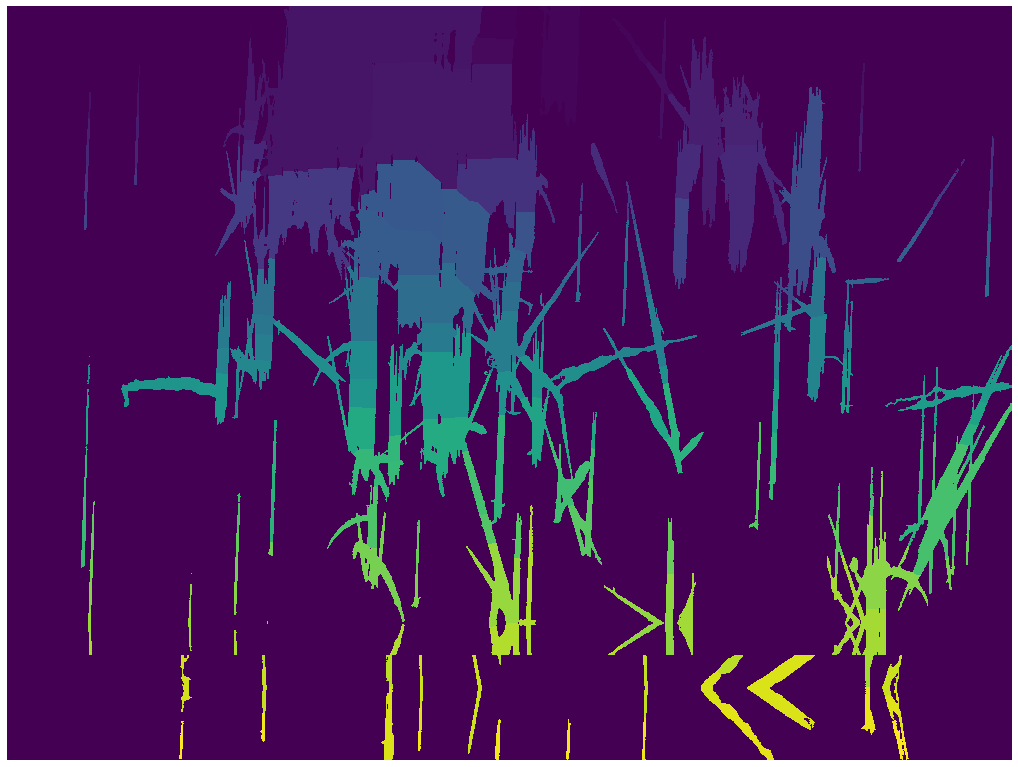

In [8]:
seg, num_seg = apply_watershed(img)
# cv2.imwrite(f'../data/Processed_Data/Labelled/{subdir}/More_Preprocessing/{filename}_seg', seg)

print(num_seg)
plt.imshow(seg)
plt.axis('off')

fig, ax = plt.subplots(1, 1, figsize = (18, 16))
ax.imshow(seg)
plt.axis('off')

In [16]:
help(apply_watershed)

Help on function apply_watershed in module __main__:

apply_watershed(img, invert=False, min_distance_bt_peaks=20)



# Rough Work Below (Delete Later)

(-0.5, 1023.5, 767.5, -0.5)

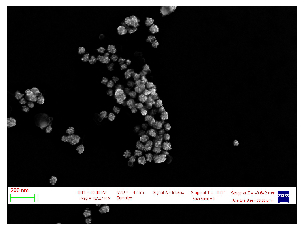

In [7]:
rand_file = np.random.choice(file_list)
img = mpimg.imread(rand_file)
plt.imshow(img)
plt.axis('off')

1.9619450569152832
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


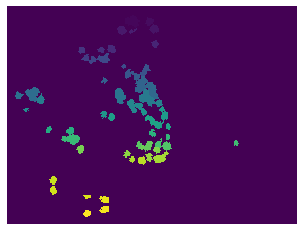

In [8]:
start = time.time()
bannerless = remove_banners(img)
seg = apply_watershed(bannerless)
print(time.time() - start)
plt.imshow(seg)
plt.axis('off')
print(seg)

(-0.5, 1023.5, 767.5, -0.5)

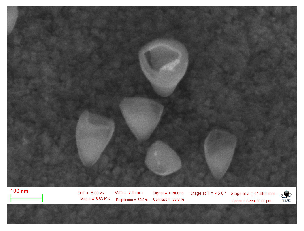

In [17]:
easy_file = '../data/Easy_to_segment/f.jpg'
img = mpimg.imread(easy_file)
plt.imshow(img)
plt.axis('off')

1.8626720905303955


(-0.5, 1023.5, 767.5, -0.5)

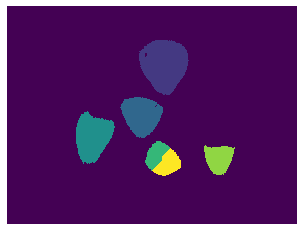

In [18]:
start = time.time()
bannerless = remove_banners(img)
seg = apply_watershed(bannerless)
print(time.time() - start)
plt.imshow(seg)
plt.axis('off')

In [325]:
print(img[0])

[[113 113 113]
 [103 103 103]
 [106 106 106]
 ...
 [ 68  68  68]
 [ 69  69  69]
 [ 67  67  67]]


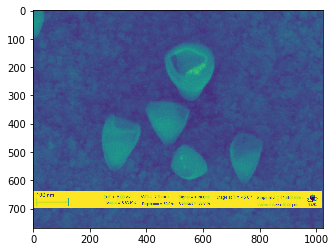

In [326]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray)

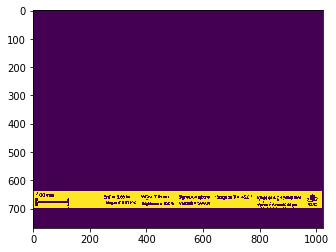

In [327]:
threshold = 250
ret, thresh = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
plt.imshow(thresh)

In [328]:
verticle_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 13))
horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (13, 1))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))

img_v = cv2.erode(thresh, verticle_kernel, iterations = 3)
vert_lines_img = cv2.dilate(img_v, verticle_kernel, iterations = 3)

img_h = cv2.erode(thresh, horizontal_kernel, iterations = 3)
hori_lines_img = cv2.dilate(img_h, horizontal_kernel, iterations = 3)

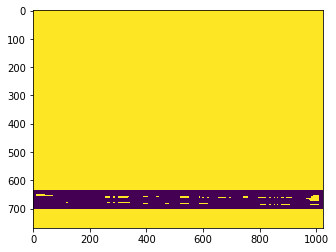

In [329]:
alpha = 0.5
beta = 1.0 - alpha
img_final = cv2.addWeighted(vert_lines_img, alpha, hori_lines_img, beta, 0.0)
img_final = cv2.erode(~img_final, kernel, iterations = 2)
ret, thresh2 = cv2.threshold(img_final, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
plt.imshow(thresh2)

In [330]:
banner = np.argwhere(thresh2 == 0)
banner_x1, banner_y1 = banner[0, 1], banner[0, 0]
banner_x2, banner_y2 = banner[-1, 1], banner[-1, 0]

banner_width, banner_height = banner_x2 - banner_x1, banner_y2 - banner_y1

bot_reflect = img[banner_y2:int(np.ceil(banner_y2 + banner_height / 2)), banner_x1:banner_x2, :]
bot_reflect = np.flipud(bot_reflect)

top_reflect = img[banner_y1 - (banner_height - len(bot_reflect)):banner_y1, banner_x1:banner_x2, :]
top_reflect = np.flipud(top_reflect)


reflect_pad = np.concatenate((top_reflect, bot_reflect), axis = 0)
print(reflect_pad.shape)

(67, 1023, 3)


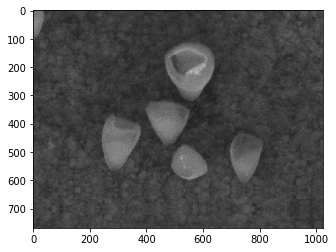

In [331]:
imgcopy = img.copy()
imgcopy[banner_y1:banner_y2, banner_x1:banner_x2] = reflect_pad
plt.imshow(imgcopy)

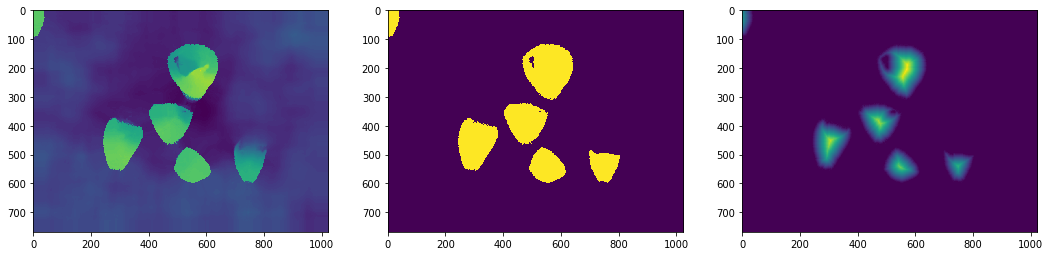

In [332]:
shifted = cv2.pyrMeanShiftFiltering(imgcopy, 41, 51)
graycopy = cv2.cvtColor(shifted, cv2.COLOR_BGR2GRAY)
ret, thresholded = cv2.threshold(graycopy, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

dt = cv2.distanceTransform(thresholded, 2, 3)


fig, ax = plt.subplots(1, 3, figsize = (18, 16))
ax[0].imshow(graycopy)
ax[1].imshow(thresholded)
ax[2].imshow(dt)

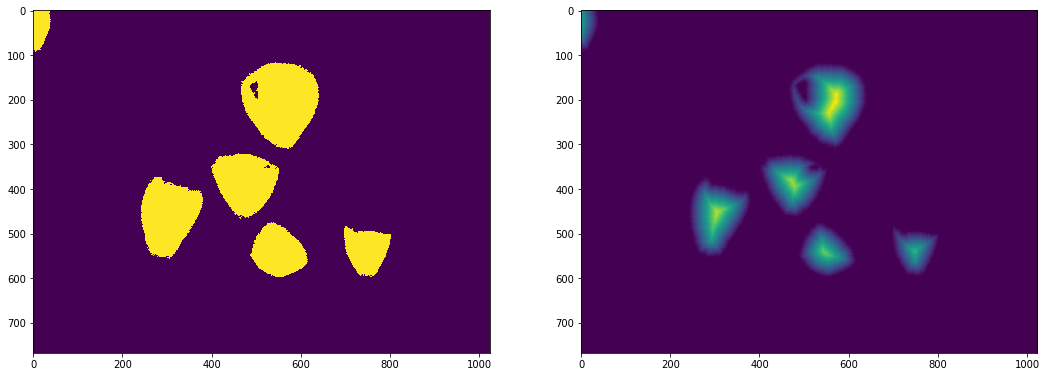

In [333]:
def kern(n):
    return np.ones((n, n), np.uint8)
    
morph = thresholded
#morph = 255 - thresholded

#morph = cv2.erode(morph, kern(3), iterations = 1)  # erosion
#morph = cv2.dilate(morph, kern(3), iterations = 2)  # dilation
#morph = cv2.morphologyEx(morph, cv2.MORPH_OPEN, kern(3), iterations = 3)  # opening
#morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kern(3), iterations = 2)  # closing

dt = cv2.distanceTransform(morph, 2, 3)

fig, ax = plt.subplots(1, 2, figsize = (18, 16))
ax[0].imshow(morph)
ax[1].imshow(dt)

6


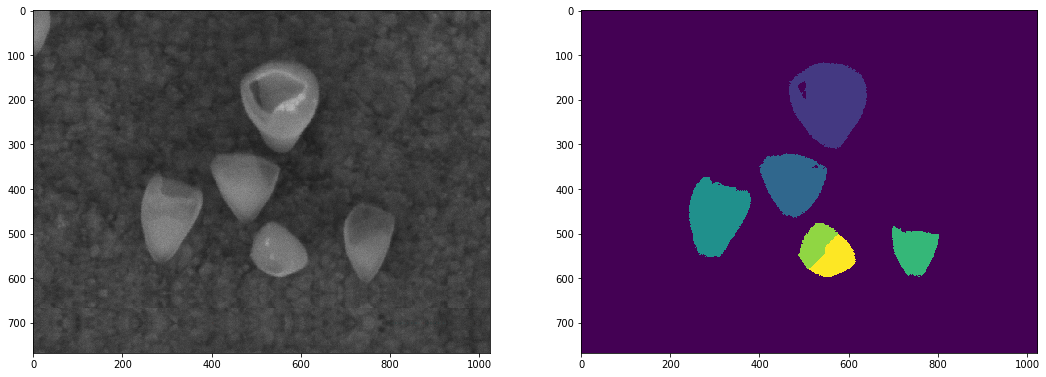

In [337]:
min_distance_bt_peaks = 20
localmax = peak_local_max(dt, indices = False, min_distance = min_distance_bt_peaks, labels = morph)
markers, num_seg = label(localmax, structure=np.ones((3, 3)))
labels = watershed(-dt, markers, mask=morph)
fig, ax = plt.subplots(1, 2, figsize = (18, 16))
ax[0].imshow(imgcopy)
ax[1].imshow(labels)
print(num_seg)

In [49]:
help(cv2.distanceTransform)

Help on built-in function distanceTransform:

distanceTransform(...)
    distanceTransform(src, distanceType, maskSize[, dst[, dstType]]) -> dst
    .   @overload
    .   @param src 8-bit, single-channel (binary) source image.
    .   @param dst Output image with calculated distances. It is a 8-bit or 32-bit floating-point,
    .   single-channel image of the same size as src .
    .   @param distanceType Type of distance, see #DistanceTypes
    .   @param maskSize Size of the distance transform mask, see #DistanceTransformMasks. In case of the
    .   #DIST_L1 or #DIST_C distance type, the parameter is forced to 3 because a \f$3\times 3\f$ mask gives
    .   the same result as \f$5\times 5\f$ or any larger aperture.
    .   @param dstType Type of output image. It can be CV_8U or CV_32F. Type CV_8U can be used only for
    .   the first variant of the function and distanceType == #DIST_L1.

